<a href="https://colab.research.google.com/github/syedanida/Decision-Trees-and-Ensemble/blob/main/randomForest_fromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required libraries
!pip install matplotlib scikit-learn pandas

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter

In [3]:
# Decision Tree Implementation (as base learners for Random Forest)
class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y, depth=0):
        n_samples, n_features = X.shape
        if len(set(y)) == 1 or depth == self.max_depth:
            self.tree = Counter(y).most_common(1)[0][0]
            return

        best_feature, best_threshold = self._best_split(X, y)
        if best_feature is None:
            self.tree = Counter(y).most_common(1)[0][0]
            return

        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold

        self.tree = {
            'feature': best_feature,
            'threshold': best_threshold,
            'left': DecisionTree(max_depth=self.max_depth),
            'right': DecisionTree(max_depth=self.max_depth)
        }

        self.tree['left'].fit(X[left_indices], y[left_indices], depth + 1)
        self.tree['right'].fit(X[right_indices], y[right_indices], depth + 1)

    def predict(self, X):
        if isinstance(self.tree, dict):
            feature = self.tree['feature']
            threshold = self.tree['threshold']
            if X[feature] <= threshold:
                return self.tree['left'].predict(X)
            else:
                return self.tree['right'].predict(X)
        else:
            return self.tree

    def _best_split(self, X, y):
        n_samples, n_features = X.shape
        best_gain = -1
        best_feature = None
        best_threshold = None

        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_indices = X[:, feature] <= threshold
                right_indices = X[:, feature] > threshold
                if sum(left_indices) == 0 or sum(right_indices) == 0:
                    continue

                gain = self._information_gain(y, left_indices, right_indices)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _information_gain(self, y, left_indices, right_indices):
        def gini_impurity(y_subset):
            if len(y_subset) == 0:
                return 0
            counts = Counter(y_subset)
            probabilities = [count / len(y_subset) for count in counts.values()]
            return 1 - sum(p ** 2 for p in probabilities)

        left_impurity = gini_impurity(y[left_indices])
        right_impurity = gini_impurity(y[right_indices])
        n = len(y)
        n_left = sum(left_indices)
        n_right = sum(right_indices)

        return gini_impurity(y) - (n_left / n) * left_impurity - (n_right / n) * right_impurity

In [4]:
# Random Forest Implementation
class RandomForest:
    def __init__(self, n_estimators=10, max_depth=None, max_features=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        n_samples, n_features = X.shape
        self.max_features = self.max_features or int(np.sqrt(n_features))

        for _ in range(self.n_estimators):
            bootstrap_indices = np.random.choice(n_samples, n_samples, replace=True)
            X_bootstrap = X[bootstrap_indices]
            y_bootstrap = y[bootstrap_indices]

            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X_bootstrap[:, np.random.choice(n_features, self.max_features, replace=False)], y_bootstrap)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(x) for tree in self.trees for x in X])
        tree_preds = tree_preds.reshape(self.n_estimators, len(X)).T
        return np.array([Counter(tree_pred).most_common(1)[0][0] for tree_pred in tree_preds])


In [5]:
# Load the Iris Dataset
iris = load_iris()
X = iris.data
y = iris.target

In [6]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Train the Random Forest model
rf = RandomForest(n_estimators=10, max_depth=5, max_features=2)
rf.fit(X_train, y_train)

In [8]:
# Make predictions
y_pred = rf.predict(X_test)

In [9]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Set: {accuracy}")

Accuracy on Test Set: 0.36666666666666664


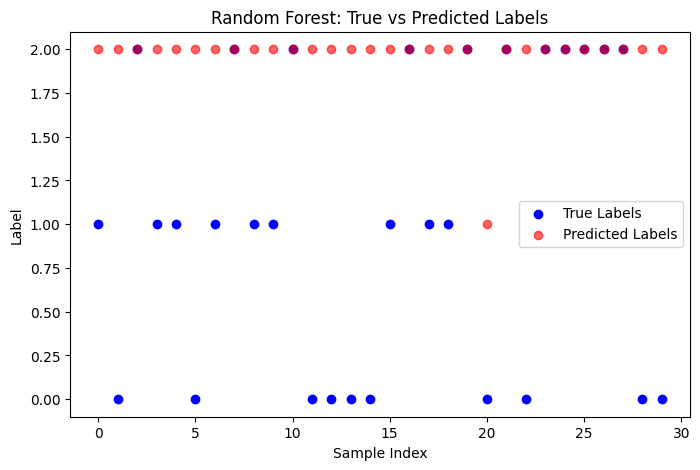

In [11]:
import matplotlib.pyplot as plt

# Visualize the results
plt.figure(figsize=(8, 5))
plt.scatter(range(len(y_test)), y_test, label="True Labels", c="blue")
plt.scatter(range(len(y_pred)), y_pred, label="Predicted Labels", c="red", alpha=0.6)
plt.legend()
plt.title("Random Forest: True vs Predicted Labels")
plt.xlabel("Sample Index")
plt.ylabel("Label")
plt.show()